In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports

In [3]:
# Make modules available
import sys
sys.path.insert(1, "./modules")

# General imports
import os
import cv2
import torch
import numpy as np
import torchvision
from scipy import ndimage
from importlib import reload
from torch.utils.data import DataLoader, random_split

# Import modules
from model import *
from dataset import *
from helpers import *

# Make randomicity reproduceable
torch.manual_seed(24)

# Load Dataset

In [5]:
batch_size = 1

In [6]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [7]:
# Create custom dataset
dataset_seg = SegmentationDataset('./Dataset/segmentation') # or define the w, 

In [8]:
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [9]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [10]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


In [11]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=batch_size, shuffle=True)
train_loader_seg = DataLoader(train_seg, batch_size=batch_size, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=batch_size, shuffle=True)

Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


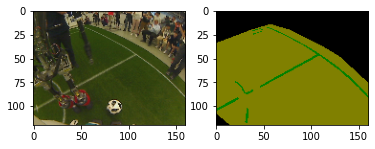

In [12]:
# Just as a sanity check display the test set
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(downsample(image)[0], downsample(target)[0])

    break

# Load Trained Model

In [15]:
# Model
model = Model(device,640,480)
model = to_device(model, device)

In [16]:
model.eval()
print("Model ready for evaluation...")

Model ready for evaluation...


In [17]:
model.load_state_dict(torch.load("/home/user/taouil/NimbRoNet2/models/model_v3_149.pt"), strict=False)

<All keys matched successfully>

# Visual Inspection

In [22]:
#dataset_seg.set_resolution(480,640)

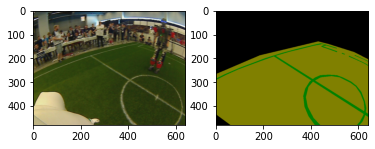

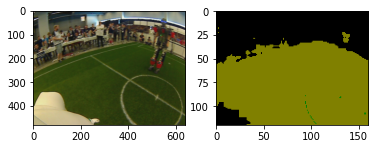

In [20]:
for image, target in test_loader_seg:    
    output = model(to_device(image,device), head="segmentation")
    
    
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
            
    # Get predictions from the maximum value
    _, predicted = torch.max(softmax_output, 1)
    
    predicted = predicted.detach()
    show_image_and_seg(image[0], target[0])
    show_image_and_seg(image[0], predicted.cpu())
    break

# Metric Evaluation

In [21]:
accuracy,iou = model.validation_segmentation(test_loader_seg)
print('Accuracy',accuracy)
print('IOU',iou)

Accuracy {'Total': 90.96067415730337, 'Field': 98.27131553079566, 'Lines': 5.742456713794539, 'Background': 86.94727182803615}
IOU {'Field': 0.872638579386609, 'Lines': 0.05727356604644011, 'Background': 0.8412485547181595, 'Total': 0.5903869000504028}
